In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Check device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device (PyTorch):", device)

# Check device for TensorFlow
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available (TensorFlow)")
else:
    print("GPU is not available (TensorFlow)")


In [ ]:
DATASET_PATHS = {
    "Crema": "../datasets/CREMA_D",
    "Ravdess": "../datasets/RAVDESS",
    "Savee": "../datasets/SAVEE",
    "Tess": "../datasets/TESS",
}

EMOTION_MAPPINGS = {
    "Ravdess": {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
                5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'},
    "Crema": {'SAD': 'sad', 'ANG': 'angry', 'DIS': 'disgust',
              'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral'},
    "Tess": {'neutral': 'neutral', 'happy': 'happy', 
             'sad': 'sad', 'angry': 'angry', 
             'fear': 'fear', 'disgust': 'disgust', 'ps': 'surprise'},
    "Savee": {'a': 'angry', 'd': 'disgust', 'f': 'fear',
              'h': 'happy', 'n': 'neutral', 'sa': 'sad'}
}

In [ ]:
def load_dataset(dataset_name):
    path = DATASET_PATHS[dataset_name]
    emotion_map = EMOTION_MAPPINGS[dataset_name]
    
    file_emotion = []
    file_path = []
    
    if dataset_name == "Ravdess":
        for actor_dir in os.listdir(path):
            actor_path = os.path.join(path, actor_dir)
            if os.path.isdir(actor_path):
                for file in os.listdir(actor_path):
                    if file.endswith('.wav'):
                        parts = file.split('-')
                        emotion_code = int(parts[2])
                        file_emotion.append(emotion_map[emotion_code])
                        file_path.append(os.path.join(actor_path, file))
    
    elif dataset_name == "Crema":
        for file in os.listdir(path):
            if file.endswith('.wav'):
                parts = file.split('_')
                emotion_code = parts[2]
                file_emotion.append(emotion_map.get(emotion_code, 'unknown'))
                file_path.append(os.path.join(path, file))
    
    elif dataset_name == "Tess":
        for emotion_dir in os.listdir(path):
            emotion_path = os.path.join(path, emotion_dir)
            if os.path.isdir(emotion_path):
                emotion = emotion_dir.split('_')[-1].lower()
                for file in os.listdir(emotion_path):
                    if file.endswith('.wav'):
                        file_emotion.append(emotion_map.get(emotion, 'unknown'))
                        file_path.append(os.path.join(emotion_path, file))
    
    elif dataset_name == "Savee":
        for file in os.listdir(path):
            if file.endswith('.wav'):
                emotion_code = file.split('_')[1][0]
                file_emotion.append(emotion_map.get(emotion_code, 'unknown'))
                file_path.append(os.path.join(path, file))
    
    return pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})


In [ ]:
def combine_datasets():
    dfs = []
    for dataset in DATASET_PATHS:
        df = load_dataset(dataset)
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df[combined_df['Emotions'].isin(['sad', 'angry', 'happy', 'fear', 'neutral'])]

In [ ]:
def extract_features(data, sr):
    result = []
    
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data))
    rms = np.mean(librosa.feature.rms(y=data))
    
    stft = np.abs(librosa.stft(data))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr))
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr))
    
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr))
    
    return np.hstack([zcr, chroma, mfcc, rms, mel])

In [ ]:
def augment_data(data, sr):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    noisy = data + noise_amp * np.random.normal(size=data.shape[0])

    stretched = librosa.effects.time_stretch(data, rate=0.8)

    pitched = librosa.effects.pitch_shift(data, sr=sr, n_steps=0.7)
    
    return [noisy, stretched, pitched]

In [ ]:
def process_audio_file(file_path):
    data, sr = librosa.load(file_path, duration=2.5, offset=0.6)
    features = [extract_features(data, sr)]
    
    for augmented in augment_data(data, sr):
        features.append(extract_features(augmented, sr))
    
    return features

In [ ]:
def prepare_data(df):
    X = []
    Y = []
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_audio_file, df['Path']))
    
    for idx, features in enumerate(results):
        X.extend(features)
        Y.extend([df.iloc[idx]['Emotions']] * len(features))
    
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X))
    
    encoder = OneHotEncoder()
    Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()
    
    return train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
def build_model(input_shape, num_classes):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        LSTM(64),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50):
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=64,
        callbacks=[lr_reduction]
    )
    return history

In [ ]:
def evaluate_model(model, X_test, y_test, encoder):
    y_pred = model.predict(X_test)
    y_true = encoder.inverse_transform(y_test)
    y_pred_labels = encoder.inverse_transform(y_pred)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_labels))
    
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', 
               xticklabels=encoder.categories_[0], 
               yticklabels=encoder.categories_[0])
    plt.title('Confusion Matrix')
    plt.show()

In [31]:
df = combine_datasets()
X_train, X_test, y_train, y_test = prepare_data(df)

Epoch 1/50


c:\Users\10\anaconda3\envs\conda_venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2561 - loss: 1.5884 - val_accuracy: 0.2858 - val_loss: 1.5597 - learning_rate: 1.0000e-04
Epoch 2/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2891 - loss: 1.5514 - val_accuracy: 0.2979 - val_loss: 1.5435 - learning_rate: 1.0000e-04
Epoch 3/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3040 - loss: 1.5325 - val_accuracy: 0.3068 - val_loss: 1.5283 - learning_rate: 1.0000e-04
Epoch 4/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3123 - loss: 1.5232 - val_accuracy: 0.3186 - val_loss: 1.5100 - learning_rate: 1.0000e-04
Epoch 5/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3294 - loss: 1.5029 - val_accuracy: 0.3467 - val_loss: 1.4795 - learning_rate: 1.0000e-04
Epoch 6/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3437 - loss: 1.4721 - val_accuracy: 0.3519 - val_loss: 1.4392 - learning_rate: 1.0000e-04
Epoch 7/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3393 - lo

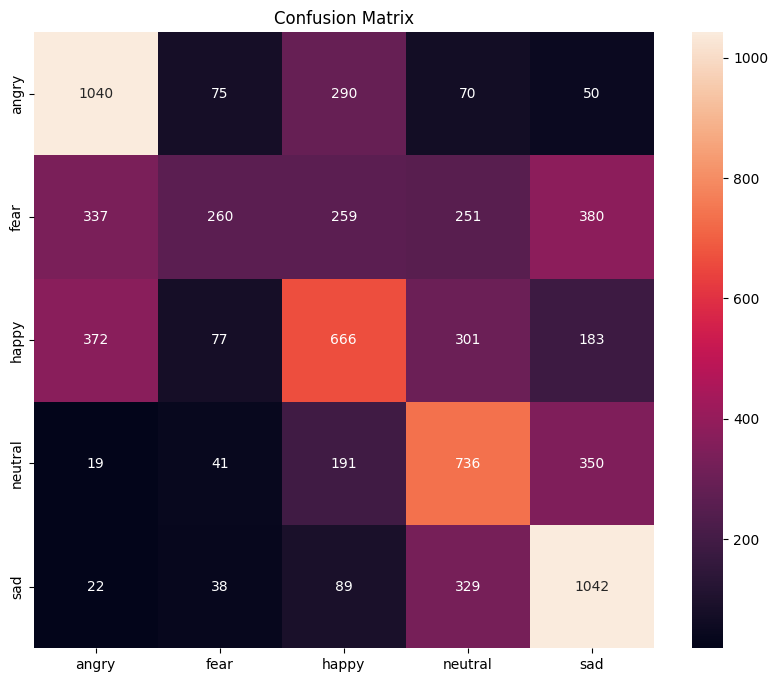

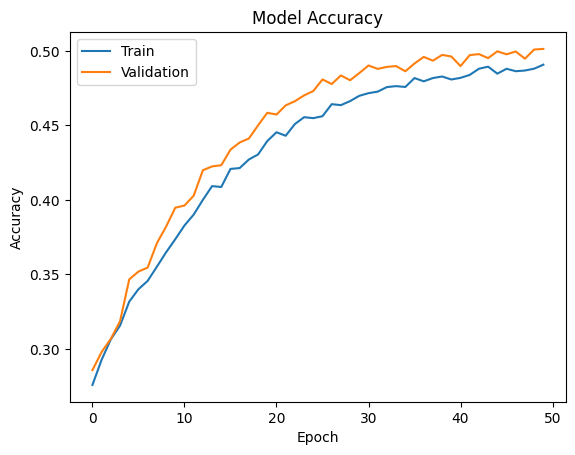

In [32]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
input_shape = (X_train.shape[1], 1)

model = build_model(input_shape, y_train.shape[1])

history = train_model(model, X_train, y_train, X_test, y_test)

evaluate_model(model, X_test, y_test, OneHotEncoder().fit(df[['Emotions']]))

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()    
plt.show()
